<div style="display: flex; align-items: center;">
    <img alt="udeA logo" height="140px" src="https://github.com/freddyduitama/images/blob/master/logo.png?raw=true" style="width:107px;height:152px; margin-right: 40px;">
    <div style="text-align: center;">
        <h1><b><font color='0B5345'>Trabajo 1: Imagenes médicas</font></b></h1>
        <h2><font color='0B5345'>Luisa Fernanda Enciso - Juan Diego Caguasango</font></h2>
    </div>
</div>

In [4]:
import pydicom
import matplotlib.pyplot as plt
from pydicom.data import get_testdata_file
from pydicom import dcmread
import pandas as pd
from collections import defaultdict


<hr>
<h3><strong>1. Análisis de metadatos dicom y visualización</strong></h3>

**1.1.  Extraer y analizar los metadatos DICOM**


 Utilizar pydicom para extraer la metadata

In [5]:
# Ruta absoluta al archivo DICOM (puedes usar también rutas relativas si estás en el mismo directorio)
fpath = "Patient01/100/74741.4976.61812.26868.17427.42996.33493.37530.34501.100.29.dcm"

ds = dcmread(fpath) # Lectura del archivo DICOM

ds # Imprimir el contenido completo del objeto DICOM (metadatos + cabecera + estructura)

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 176
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 74741.4976.61812.26868.17427.42996.33493.37530.34501.100.9
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.2.773
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 192'
(0008,0008) Image Type                          CS: ['DERIVED', 'SECONDARY', 'AXIAL']
(0008,0016) SOP Class UID                       UI: CT Image Storage
(0008,0018) SOP Instance UID                    UI: 74741.4976.61812.26868.17427.42996.33493.37530.34501.100.9
(0008,0020) Study Date                          DA: '20230821'
(0008,0021) Series Date                         DA


<h3><strong>Comfirmar Modalidad de imagen </strong></h3>

In [6]:
ds.Modality

'CT'

Se busca la metadata solicitada : 

• PatientName • Modality • SliceThickness • kVp • BodyPartExamined • Relative X-Ray Exposure • ExposureTime • Photometric Interpretation • Manufacturer • Scanner Model

In [7]:
# Extraer metadata
fields = {
    "PatientName": getattr(ds, "PatientName", None),
    "Modality": getattr(ds, "Modality", None),
    "SliceThickness": getattr(ds, "SliceThickness", None),
    "KVP": getattr(ds, "KVP", None),
    "BodyPartExamined": getattr(ds, "BodyPartExamined", None),
    "RelativeXRayExposure": getattr(ds, "RelativeXRayExposure", None),
    "ExposureTime": getattr(ds, "ExposureTime", None),
    "PhotometricInterpretation": getattr(ds, "PhotometricInterpretation", None),
    "Manufacturer": getattr(ds, "Manufacturer", None),
    "ManufacturerModelName": getattr(ds, "ManufacturerModelName", None),
}

# Mostrar resultados
for key, value in fields.items():
    if value is None or (isinstance(value, str) and value.strip() == ""):
        value = "No disponible"
    print(f"{key}: {value}")

PatientName: anonymize
Modality: CT
SliceThickness: 0
KVP: 85
BodyPartExamined: No disponible
RelativeXRayExposure: No disponible
ExposureTime: No disponible
PhotometricInterpretation: MONOCHROME2
Manufacturer: Sirona
ManufacturerModelName: No disponible


 Organizar la metadata extraída en Name, Tag, Type y Value, explique a qué hace referencia 
cada uno de ellos, el grupo al que pertenece, su relevancia y los valores válidos para ese 
metadato.

In [8]:
print("Buscamos palabras relacionadas a lo especificado: ",ds.dir('Manufac') )# Comando para buscar la data necesaria
print("Encontramos el objeto: ",ds.data_element('Manufacturer'))
print("Solo miramos el tag: ",ds.data_element('Manufacturer').tag)
print("Ahora con el tag podemos extraer la info: ",ds.get((0x0008, 0x0070))) #extrare los datos con solo el tag

Buscamos palabras relacionadas a lo especificado:  ['Manufacturer', 'ManufacturerModelName']
Encontramos el objeto:  (0008,0070) Manufacturer                        LO: 'Sirona'
Solo miramos el tag:  (0008,0070)
Ahora con el tag podemos extraer la info:  (0010,0010) Patient's Name                      PN: 'anonymize'


In [9]:
tags = [
    (0x0010, 0x0010),  # Patient's Name
    (0x0008, 0x0060),  # Modality
    (0x0018, 0x0050),  # Slice Thickness
    (0x0018, 0x0060),  # KVP
    (0x0018, 0x0015),  # Body Part Examined
    (0x0028, 0x0004),  # Photometric Interpretation
    (0x0008, 0x0070),  # Manufacturer
    (0x0008, 0x1090),  # Manufacturer Model Name
]

data_list = []
for group, element in tags:
    tag = (group, element)
    data_element = ds.get(tag)
    if data_element:
        raw_value = data_element.value

        if raw_value is None or (isinstance(raw_value, str) and raw_value.strip() == ""):
            value = "No disponible"
        else:
            value = str(raw_value)

        data_list.append({
            "Name": data_element.name,
            "Tag": f"({group:04X},{element:04X})", # Formato hexadecimal
            "Type": data_element.VR,
            "Value": value,
            "Grupo": f"{group:04X}"
        })

# Colocamos los valores que no se encuentran en el archivo DICOM
data_list.append({
        "Name": "RelativeXRayExposure",
        "Tag": "No disponible",
        "Type": "No disponible",
        "Value": "No disponible",
        "Grupo": "No disponible"
        })
data_list.append({
        "Name": "ExposureTime",
        "Tag":"No disponible",
        "Type": "No disponible",
        "Value": "No disponible",
        "Grupo": "No disponible"})

df = pd.DataFrame(data_list)
df


,Name,Tag,Type,Value,Grupo
0,Patient's Name,"(0010,0010)",PN,anonymize,0010
1,Modality,"(0008,0060)",CS,CT,0008
2,Slice Thickness,"(0018,0050)",DS,0,0018
3,KVP,"(0018,0060)",DS,85,0018
4,Body Part Examined,"(0018,0015)",CS,No disponible,0018
5,Photometric Interpretation,"(0028,0004)",CS,MONOCHROME2,0028
6,Manufacturer,"(0008,0070)",LO,Sirona,0008
7,Manufacturer's Model Name,"(0008,1090)",LO,No disponible,0008
8,RelativeXRayExposure,No disponible,No disponible,No disponible,No disponible
9,ExposureTime,No disponible,No disponible,No disponible,No disponible


In [10]:
df['Relevancia y Referencia'] = [
    
    "Este campo es crucial para la identificación del paciente en el registro clínico. En investigaciones, se anonimiza para proteger la privacidad.",
    "Este valor indica el tipo de modalidad de imagen utilizada. Es fundamental para la interpretación de la imagen y su procesamiento automatizado.",
    "El grosor de cada corte de la imagen, expresado en milímetros. Un valor de 0 podría ser un marcador temporal o placeholder.",
    "El kilovoltaje pico utilizado durante la adquisición de la imagen. Este valor influye en la calidad de la imagen y la dosis de radiación aplicada.",
    "Identifica la parte del cuerpo que fue examinada en la imagen. Es importante para la organización y análisis de las imágenes.",
    "Este valor define cómo deben interpretarse los píxeles en la imagen. En el caso de 'MONOCHROME2', los valores más bajos indican áreas oscuras en la imagen.",
    "Indica el fabricante del equipo de imagen utilizado. Esta información es útil para el soporte técnico, trazabilidad del equipo y análisis comparativo.",
    "Proporciona el modelo del equipo de imagen utilizado, lo que ayuda a estandarizar los estudios y facilitar la resolución de problemas específicos del dispositivo.",
    "Hace referencia al nivel de exposición radiográfica, medido en mAs. Es un dato clave para evaluar la dosis de radiación recibida.",
    "Hace referencia al nivel de exposición radiográfica, medido en mAs. Es un dato clave para evaluar la dosis de radiación recibida."
]

df

,Name,Tag,Type,Value,Grupo,Relevancia y Referencia
0,Patient's Name,"(0010,0010)",PN,anonymize,0010,Este campo es crucial para la identificación d...
1,Modality,"(0008,0060)",CS,CT,0008,Este valor indica el tipo de modalidad de imag...
2,Slice Thickness,"(0018,0050)",DS,0,0018,"El grosor de cada corte de la imagen, expresad..."
3,KVP,"(0018,0060)",DS,85,0018,El kilovoltaje pico utilizado durante la adqui...
4,Body Part Examined,"(0018,0015)",CS,No disponible,0018,Identifica la parte del cuerpo que fue examina...
5,Photometric Interpretation,"(0028,0004)",CS,MONOCHROME2,0028,Este valor define cómo deben interpretarse los...
6,Manufacturer,"(0008,0070)",LO,Sirona,0008,Indica el fabricante del equipo de imagen util...
7,Manufacturer's Model Name,"(0008,1090)",LO,No disponible,0008,Proporciona el modelo del equipo de imagen uti...
8,RelativeXRayExposure,No disponible,No disponible,No disponible,No disponible,Hace referencia al nivel de exposición radiogr...
9,ExposureTime,No disponible,No disponible,No disponible,No disponible,Hace referencia al nivel de exposición radiogr...


<h3>Referencias útiles de DICOM:</h3>
<ul>
  <li><a href="https://www.dicomlibrary.com/dicom/dicom-tags/" target="_blank">DicomLibrary - Lista de tags DICOM</a></li>
  <li><a href="https://dicom.innolitics.com/ciods/ct-image/patient/00100010" target="_blank">Innolitics - Tag específico Patient's Name (0010,0010)</a></li>
  <li><a href="https://dicom.nema.org/medical/dicom/current/output/chtml/part06/chapter_6.html" target="_blank">NEMA - Estándar oficial DICOM (Capítulo 6)</a></li>
</ul>

**1.2. Interpretación Técnica**


 Explicar cómo los parámetros técnicos se relacionan con el principio físico de la modalidad 
seleccionada. 

<h3><strong>Parámetros Técnicos en Tomografía Computarizada (CT)</strong></h3>

<h4><strong>1. Grosor de Corte:</strong></h4>
<p>El grosor de corte es de <strong>0 mm</strong>. Un grosor más delgado se desea para mejorar la resolución en la profundidad, pero aumenta la dosis de radiación. Sin embargo, al ser cero en este caso, no debió ser registrado o se perdió la resolución en el proceso.</p>

<h4><strong>2. KVP (Kilovoltaje Pico):</strong></h4>
<p><strong>KVP = 85 kV</strong>. Controla la penetración de los rayos X, por lo que energías altas atraviesan los huesos, mientras que energías bajas mejoran el contraste en los tejidos blandos. Un kVp de 85 es adecuado para exámenes de tejidos blandos, minimizando la radiación pero manteniendo un buen contraste, como en el caso de la cavidad bucal en este caso.</p>

<h4><strong>3. Interpretación Fotométrica:</strong></h4>
<p><strong>MONOCHROME2</strong>: Los diferentes tejidos del cuerpo absorben los rayos X en distintas cantidades, lo que se traduce en diferentes tonalidades de gris en la imagen. En este caso, los rayos X más absorbidos aparecen en blanco (hueso), y los menos absorbidos en negro (aire).</p>

<h4><strong>4. Exposición Relativa a Rayos X:</strong></h4>
<p><strong>No disponible</strong>. Generalmente, mayor exposición mejora la calidad de la imagen, pero aumenta la dosis de radiación.</p>

<h4><strong>5. Tiempo de Exposición:</strong></h4>
<p><strong>No disponible</strong>. Un mayor tiempo de exposición puede mejorar la calidad de la imagen (menos ruido), pero también incrementa la dosis de radiación.</p>


**1.3. Visualización**


 Cargar la imagen DICOM en Python y graficarla utilizando matplotlib. 

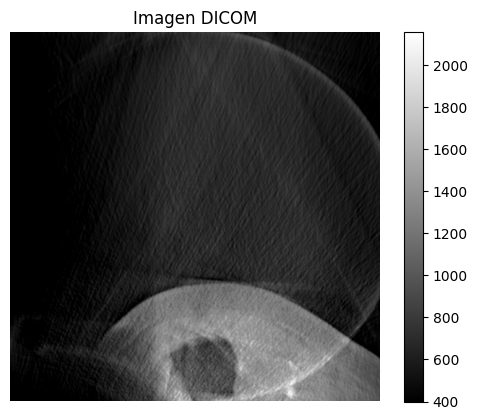

In [11]:
datasets = [ds, ds2, ds3]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, (ax, dcm) in enumerate(zip(axs, datasets)):
    image = dcm.pixel_array
    ax.imshow(image, cmap='gray')
    corte = getattr(dcm, 'InstanceNumber', None)
    ax.set_title(f"Numero de corte {corte}")
    ax.axis('off')

plt.tight_layout()
plt.show()

<hr>
<h3><strong>2. Comparación multimodal de imágenes</strong></h3>

* Identificar la modalidad de cada imagen.

In [30]:
# Lista de rutas a las imágenes DICOM
rutas_dicom = [
    "Modalidad1/201/1.3.46.670589.11.45555.5.0.8860.2024062407360802070.dcm",
    "Modalidad2/ScalarVolume_13/IMG0001.dcm",
    "Modalidad3/ScalarVolume_27/IMG0030.dcm"
]

# Leer y mostrar la modalidad de cada imagen
for idx, ruta in enumerate(rutas_dicom, start=1):
    ds = pydicom.dcmread(ruta)
    modalidad = ds.get("Modality", "No disponible")
    print(f"Modalidad {idx}: {modalidad}")


Modalidad 1: MR
Modalidad 2: CR
Modalidad 3: CT


* Comparación 

    1. Calidad visual
    2. Resolucion numerica
    3. Diferencias de contraste percibidas

In [34]:
# Diccionario para guardar una sola entrada representativa por modalidad
metadata_imagenes = {
    'CR': {},
    'MR': {},
    'CT': {}
}

# Procesar archivos DICOM
for path in rutas_dicom:
    ds = pydicom.dcmread(path)
    mod = ds.get("Modality", "Otra")

    if mod not in metadata_imagenes:
        continue  

    if not metadata_imagenes[mod]: 
        # Verificar si el dataset tiene pixel_array
        try:
            pixel_array = ds.pixel_array
            shape = pixel_array.shape
            total_pixels = pixel_array.size
            min_pixel = int(pixel_array.min())
            max_pixel = int(pixel_array.max())
            mean_pixel = float(pixel_array.mean())
            std_pixel = float(pixel_array.std())
        except AttributeError:
            shape = "No disponible"
            total_pixels = "No disponible"
            min_pixel = "No disponible"
            max_pixel = "No disponible"
            mean_pixel = "No disponible"
            std_pixel = "No disponible"

        # Guardar los metadatos
        metadata_imagenes[mod] = {
            "Shape": shape,
            "TotalPixels": total_pixels,
            "PixelSpacing": ds.get("PixelSpacing", "No disponible"),
            "SliceThickness": ds.get("SliceThickness", "No disponible"),
            "ImageOrientationPatient": ds.get("ImageOrientationPatient", "No disponible"),
            "ImagePositionPatient": ds.get("ImagePositionPatient", "No disponible"),
            "KVP": ds.get("KVP", "No disponible"),
            "ExposureTime": ds.get("ExposureTime", "No disponible"),
            "EchoTime": ds.get("EchoTime", "No disponible"),
            "PhotometricInterpretation": ds.get("PhotometricInterpretation", "No disponible"),
            "WindowCenter": ds.get("WindowCenter", "No disponible"),
            "WindowWidth": ds.get("WindowWidth", "No disponible"),
            "PixelRepresentation": ds.get("PixelRepresentation", "No disponible"),
            "BitsStored": ds.get("BitsStored", "No disponible"),
            "BitsAllocated": ds.get("BitsAllocated", "No disponible"),
            "HighBit": ds.get("HighBit", "No disponible"),
            "MinPixelValue": min_pixel,
            "MaxPixelValue": max_pixel,
            "MeanPixelValue": mean_pixel,
            "StdPixelValue": std_pixel
        }

# Lista completa de características a mostrar
caracteristicas = [
    "Shape", "TotalPixels", "PixelSpacing", "SliceThickness", "ImageOrientationPatient", "ImagePositionPatient",
    "KVP", "ExposureTime", "EchoTime", "PhotometricInterpretation", "WindowCenter",
    "WindowWidth", "PixelRepresentation", "BitsStored", "BitsAllocated", "HighBit",
    "MinPixelValue", "MaxPixelValue", "StdPixelValue"
]

# Construir tabla tipo DataFrame
tabla = {
    "Característica": caracteristicas,
    "CR": [metadata_imagenes['CR'].get(c, "No disponible") for c in caracteristicas],
    "MR": [metadata_imagenes['MR'].get(c, "No disponible") for c in caracteristicas],
    "CT": [metadata_imagenes['CT'].get(c, "No disponible") for c in caracteristicas],
}

tabla_comparacion = pd.DataFrame(tabla)
tabla_comparacion


,Característica,CR,MR,CT
0,Shape,"(2828, 2320)","(640, 640)","(512, 512)"
1,TotalPixels,6560960,409600,262144
2,PixelSpacing,No disponible,"[0.4716981, 0.4716981]","[.399608615, .399608615]"
3,SliceThickness,1.0,4.0,1.0
4,ImageOrientationPatient,"[1, 0, 0, 0, 1, 0]","[0.9998723, -1.59611e-002, 7.28958e-004, 0, -4...","[.994881, -.101038, -.00190704, -.0015692, .00..."
5,ImagePositionPatient,"[0, 0, 0]","[-142.3773, 41.844, 147.0362]","[-91.0072, 162.482, 12.2536]"
6,KVP,No disponible,No disponible,No disponible
7,ExposureTime,No disponible,No disponible,No disponible
8,EchoTime,No disponible,-1.0,No disponible
9,PhotometricInterpretation,MONOCHROME2,MONOCHROME2,MONOCHROME2


**Análisis**

En primer lugar, la imagen CR tiene el mayor tamaño en términos de píxeles (2828×2320), mientras que MR (640×640) y CT (512×512) manejan resoluciones considerablemente menores. Sin embargo, al considerar el PixelSpacing, se observa que MR y CT ofrecen un espaciado submilimétrico (aproximadamente 0.4 mm), lo que les permite capturar detalles anatómicos más finos a pesar de tener menos píxeles. La CR no tiene PixelSpacing disponible, lo cual limita su análisis de resolución. Por otra parte, el TotalPixels refuerza este hallazgo, indicando que aunque CR contiene más de seis millones de píxeles, la falta de precisión espacial y el bajo contraste observado la hacen menos eficiente para diferenciar estructuras anatómicas en comparación con MR y CT.

Respecto al SliceThickness, tanto CR como CT muestran cortes de 1 mm, lo que indica cortes delgados y adecuados para análisis detallados. En cambio, en MR es de 4.0 mm, lo cual implica cortes más gruesos que, si bien reducen la resolución espacial, permiten cubrir mayores volúmenes en menor tiempo,

La orientación de los cortes (ImageOrientationPatient) muestra que CR está perfectamente alineada a los ejes ortogonales (X e Y), lo que confirma que es una proyección plana de estructuras. Mientras que MR y CT tienen ligeras inclinaciones.

En cuanto a la interpretación de la imagen, todas las modalidades usan escala de grises MONOCHROME2, lo que significa que una menor intensidad representa valores más oscuros. Sin embargo, la dinámica de visualización varía dado que los valores de WindowCenter y WindowWidth muestran que CR maneja valores de ventana amplios (1366 de ancho), pero CT presenta el mayor WindowWidth (2028), ideal para visualizar una gran gama de tejidos (de aire a hueso). MR, con un ancho de 553, está más enfocado en detalles de tejidos blandos.

Respecto a la profundidad de bits, tanto CR como CT almacenan imágenes con 16 bits por píxel, permitiendo una representación muy rica en niveles de gris, esencial para distinguir sutiles variaciones de densidad. MR, por su parte, maneja una profundidad de 12 bits, adecuada para sus objetivos clínicos, aunque limitada en cuanto a diferenciación de intensidades extremas. A pesar de esta diferencia, MR mantiene una notable uniformidad en la representación de tejidos, evidenciada por su baja desviación estándar de intensidades (143.57), en comparación con los valores más altos observados en CR (544.98) y CT (526.86), donde la heterogeneidad de intensidades es mayor, posiblemente reflejando la diversidad de estructuras o mayor cantidad de ruido.

* Graficar las tres imagenes en un subplot 1x3 con matplotlib

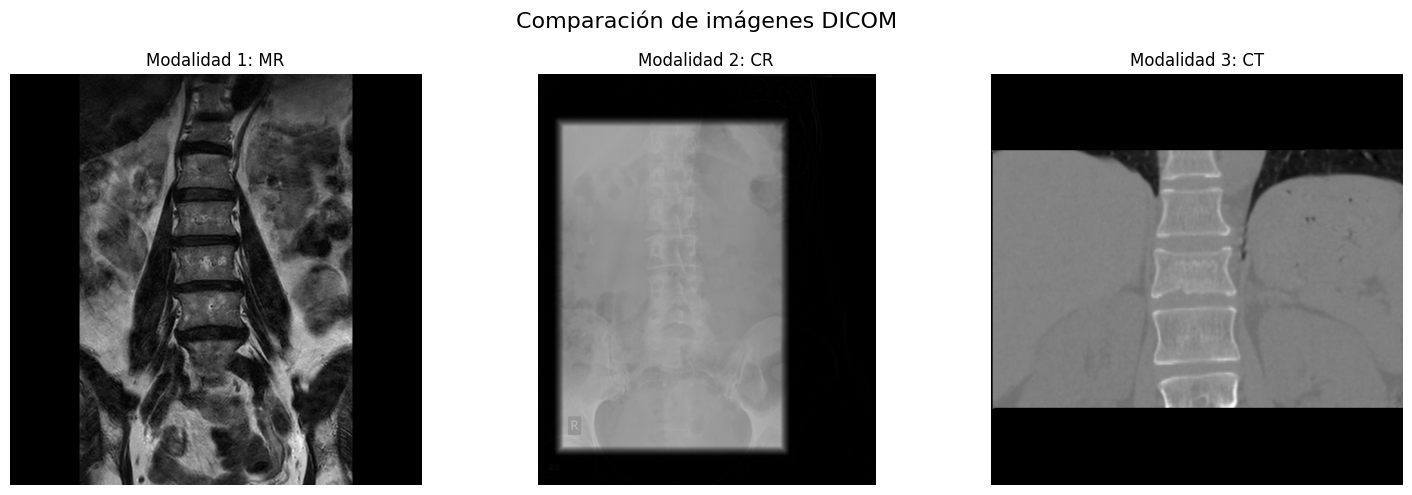

In [31]:
plt.figure(figsize=(15, 5))

# Recorrer y graficar cada imagen
for i, path in enumerate(rutas_dicom):
    ds = pydicom.dcmread(path)
    img = ds.pixel_array
    
    plt.subplot(1, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Modalidad {i + 1}: {ds.get('Modality', 'N/A')}")
    plt.axis('off')

# Título general
plt.suptitle("Comparación de imágenes DICOM", fontsize=16)
plt.tight_layout()
plt.show()

*  Incluir anotaciones y describir las diferencias encontradas. 

**Modalidad 1: MR (Resonancia Magnética)**

Se caracteriza por un excelente contraste entre los tejidos blandos. Se puede distinguir claramente los discos intervertebrales, la médula espinal dentro del canal vertebral y los tejidos musculares circundantes. La grasa aparece brillante en esta imagen, lo que ayuda a delinear las estructuras. Los huesos (vértebras) se visualizan con una intensidad de señal intermedia a baja. La nitidez de los bordes de los tejidos blandos es notable.

**Modalidad 2: CR (Rayos X)**

Las estructuras óseas (vértebras, pelvis) son las que mejor se visualizan, apareciendo de color blanco/gris claro debido a su alta densidad y mayor atenuación de los rayos X. Los tejidos blandos se visualizan con un contraste mucho menor y son más difíciles de distinguir. Se observa la superposición de todas las estructuras a lo largo de la trayectoria del haz de rayos X

**Modalidad 3: CT (Tomografía Computarizada)**

Se observa el cuerpo vertebral, el canal vertebral conteniendo la médula espinal, las apófisis espinosas y transversas, y los tejidos blandos circundantes. La CT ofrece una buena diferenciación entre tejidos con diferentes densidades. El hueso aparece muy brillante, mientras que los tejidos blandos tienen diferentes niveles de gris según su densidad. La imagen tiene una apariencia seccional, eliminando la superposición de estructuras que se ve en la radiografía.

<hr>
<h3><strong>3. Simulación de flujo de información imagenológica </strong></h3>

* Diseñar un diagrama de flujo que represente el recorrido de una imagen médica desde su solicitud hasta la visualización e informe. 

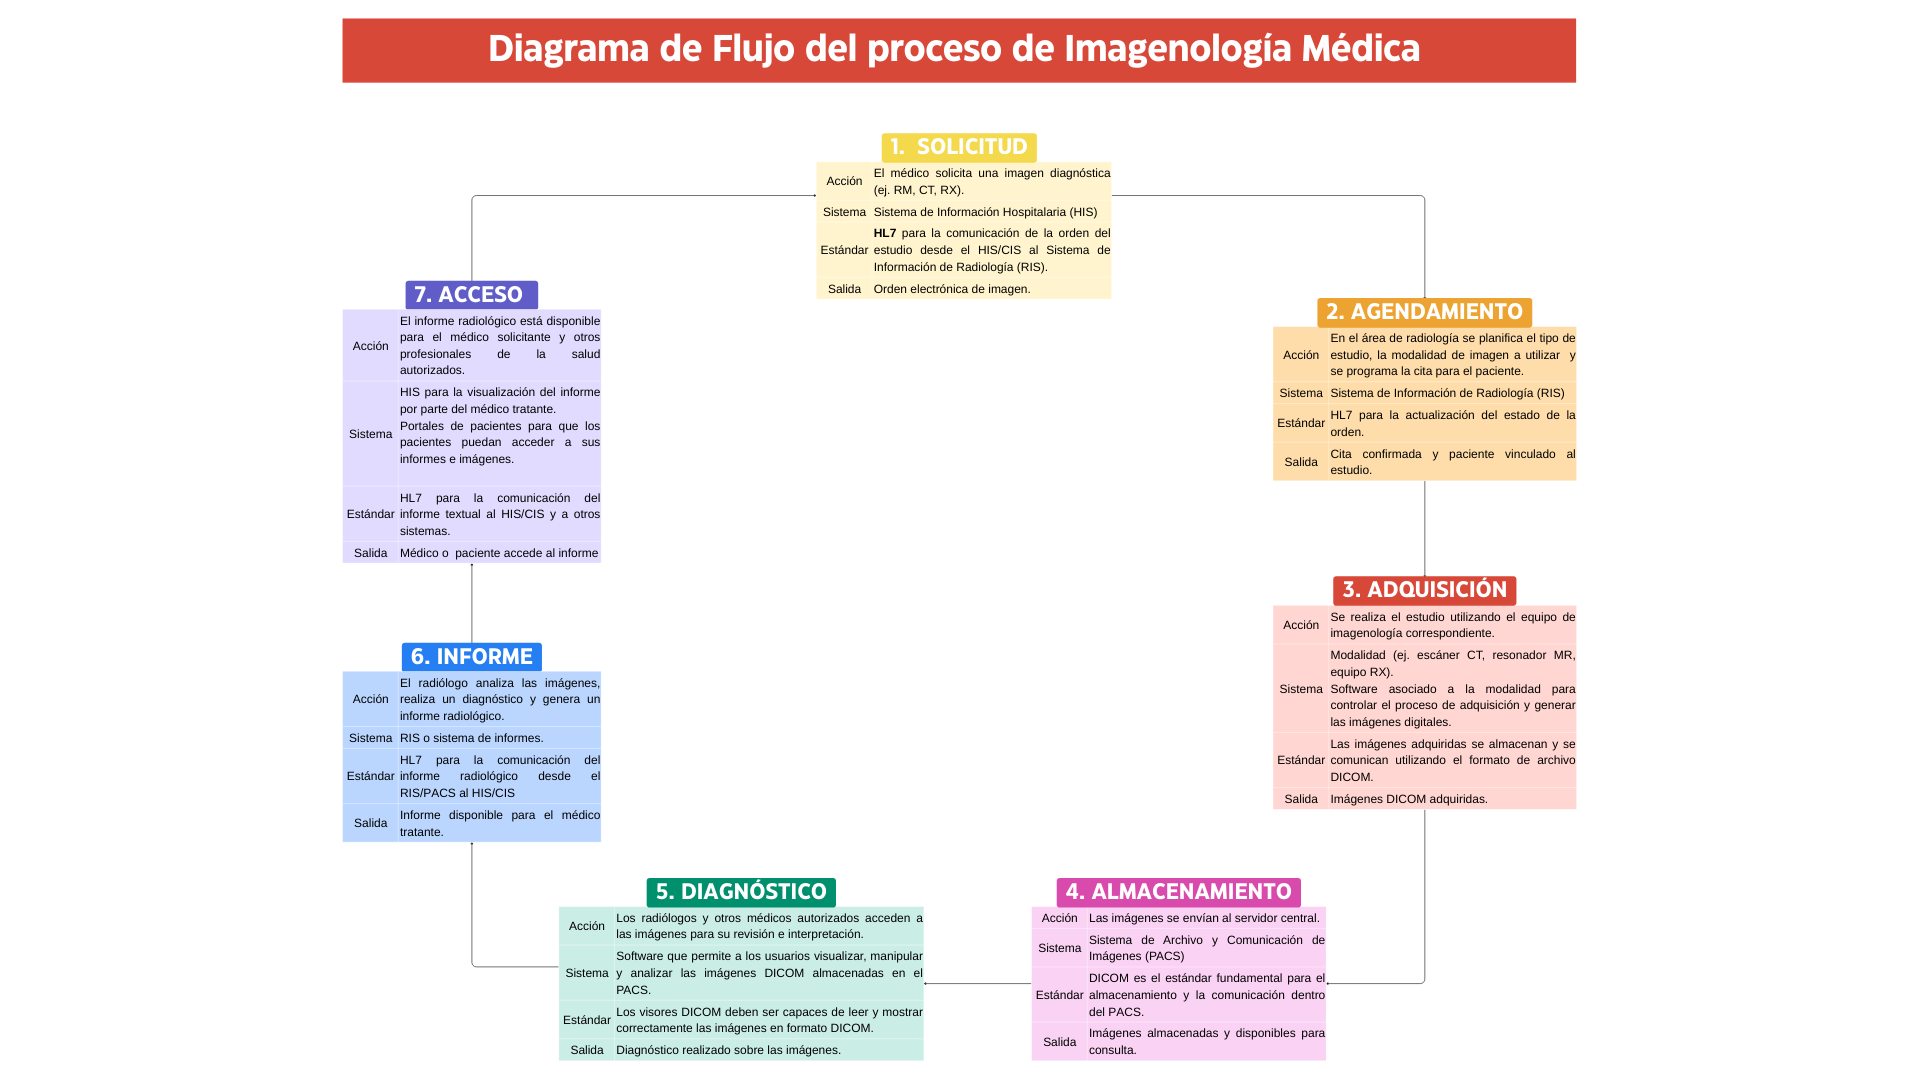

In [16]:
from IPython.display import Image, display

display(Image(filename='Diagrama_Flujo.png'))

<hr>
<h3><strong>Conclusiones </strong></h3>